In [1]:
!pip install kaggle

  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=8111932931c6aacb903e16e6a99f1beaf5dfccbc2d66c2684f5e21f97563cf8a
  Stored in directory: c:\users\kk\appdata\local\pip\cache\wheels\29\da\11\144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle


In [3]:
!kaggle competitions download -c titanic


  0%|          | 0.00/34.1k [00:00<?, ?B/s]
100%|##########| 34.1k/34.1k [00:00<00:00, 2.69MB/s]


In [4]:
import zipfile
with zipfile.ZipFile('./titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, losses
from keras.layers import Dense, Dropout, Input

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_df = pd.read_csv('test.csv')
test_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
submission_df = pd.read_csv('gender_submission.csv')
submission_df.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Preprocessing

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
for column in train_df.columns:
    print(column,len(train_df[column].unique()))

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 89
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 148
Embarked 4


In [150]:
train_X = train_df.drop('Survived', axis=1)
train_Y = train_df['Survived']

In [155]:
def preprocessing_df(df):
    df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
    df['Sex'] = df['Sex'].apply(lambda sex : 1 if sex=='male' else 0)

    df['Family'] = df.apply(lambda row : 0 if row['SibSp'] + row['Parch'] == 0 
                            else (1 if row['SibSp'] + row['Parch'] < 4 else 2), axis=1)
    df = df.drop(['SibSp', 'Parch'], axis=1)
    
    df['Embarked'] = df['Embarked'].astype('category').cat.codes
    
    df['Cabin'] = df['Cabin'].apply(lambda cabin : 0 if cabin==None else 1)
    
    male_median = df4[df4['Sex']==1]['Age'].median()
    female_median = df4[df4['Sex']==0]['Age'].median()

    def replace_age(row):
        ret = row['Age']

        if(np.isnan(ret)):
            if(row['Sex']==1):
                ret = male_median
            else:
                ret = female_median
        return ret

    df['Age'] = df.apply(replace_age, axis=1)
    
    def trans_age(x):
        if(x<20): return 0
        if(x<50): return 1
        return 2

    df['Age'] = df['Age'].apply(trans_age)

    return df
    

In [156]:
processed_X = preprocessing_df(train_X)
processed_X

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,3,1,1,7.2500,1,2,1
1,1,0,1,71.2833,1,0,1
2,3,0,1,7.9250,1,2,0
3,1,0,1,53.1000,1,2,1
4,3,1,1,8.0500,1,2,0
...,...,...,...,...,...,...,...
886,2,1,1,13.0000,1,2,0
887,1,0,0,30.0000,1,2,0
888,3,0,1,23.4500,1,2,1
889,1,1,1,30.0000,1,0,0


In [157]:
processed_X.describe()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
count,891.000000,891.000000,891.00000,891.000000,891.0,891.000000,891.000000
mean,2.308642,0.647587,0.89899,32.204208,1.0,1.529742,0.466891
std,0.836071,0.477990,0.50715,49.693429,0.0,0.800254,0.623305
min,1.000000,0.000000,0.00000,0.000000,1.0,-1.000000,0.000000
25%,2.000000,0.000000,1.00000,7.910400,1.0,1.000000,0.000000
50%,3.000000,1.000000,1.00000,14.454200,1.0,2.000000,0.000000
75%,3.000000,1.000000,1.00000,31.000000,1.0,2.000000,1.000000
max,3.000000,1.000000,2.00000,512.329200,1.0,2.000000,2.000000


In [161]:
processed_X = processed_X.copy()
scaler = StandardScaler()
processed_X['Fare'] = scaler.fit_transform(processed_X['Fare'].to_numpy().reshape(-1,1))
processed_X

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,3,1,1,-0.502445,1,2,1
1,1,0,1,0.786845,1,0,1
2,3,0,1,-0.488854,1,2,0
3,1,0,1,0.420730,1,2,1
4,3,1,1,-0.486337,1,2,0
...,...,...,...,...,...,...,...
886,2,1,1,-0.386671,1,2,0
887,1,0,0,-0.044381,1,2,0
888,3,0,1,-0.176263,1,2,1
889,1,1,1,-0.044381,1,0,0


In [163]:
processed_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       891 non-null    int64  
 3   Fare      891 non-null    float64
 4   Cabin     891 non-null    int64  
 5   Embarked  891 non-null    int8   
 6   Family    891 non-null    int64  
dtypes: float64(1), int64(5), int8(1)
memory usage: 42.8 KB


In [172]:
features = processed_X.shape[1]

In [173]:
def get_model():
    inputs = Input(shape=(features))
    
    x = Dense(16, activation='relu', kernel_initializer = "he_normal")(inputs)
    x = Dense(8, activation='relu', kernel_initializer = "he_normal")(x)
    x = Dense(4, activation='relu', kernel_initializer = "he_normal")(x)
    outputs= Dense(1, activation='sigmoid', kernel_initializer = "he_normal")(x)
    
    return keras.Model(inputs=inputs, outputs=outputs)

In [174]:
model = get_model()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_27 (Dense)            (None, 16)                128       
                                                                 
 dense_28 (Dense)            (None, 8)                 136       
                                                                 
 dense_29 (Dense)            (None, 4)                 36        
                                                                 
 dense_30 (Dense)            (None, 1)                 5         
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [175]:
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [182]:
epochs = 500
batch_size = 20
validation_split = 0.05

In [183]:
history = model.fit(processed_X, train_Y, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

Epoch 1/500
43/43 [==============================] - 0s 2ms/step - loss: 0.3898 - accuracy: 0.8381 - val_loss: 0.3611 - val_accuracy: 0.8667
Epoch 2/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3940 - accuracy: 0.8333 - val_loss: 0.3532 - val_accuracy: 0.8667
Epoch 3/500
43/43 [==============================] - 0s 1ms/step - loss: 0.4056 - accuracy: 0.8286 - val_loss: 0.3548 - val_accuracy: 0.8444
Epoch 4/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3931 - accuracy: 0.8333 - val_loss: 0.3629 - val_accuracy: 0.8667
Epoch 5/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3923 - accuracy: 0.8369 - val_loss: 0.3548 - val_accuracy: 0.8667
Epoch 6/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3909 - accuracy: 0.8262 - val_loss: 0.3556 - val_accuracy: 0.8667
Epoch 7/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3912 - accuracy: 0.8381 - val_loss: 0.3575 - val_accuracy: 0.8667
Epoch 8/500
4

Epoch 59/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3822 - accuracy: 0.8463 - val_loss: 0.3499 - val_accuracy: 0.8444
Epoch 60/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3890 - accuracy: 0.8310 - val_loss: 0.3467 - val_accuracy: 0.8667
Epoch 61/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3912 - accuracy: 0.8251 - val_loss: 0.3459 - val_accuracy: 0.8667
Epoch 62/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3863 - accuracy: 0.8333 - val_loss: 0.3482 - val_accuracy: 0.8444
Epoch 63/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3872 - accuracy: 0.8322 - val_loss: 0.3515 - val_accuracy: 0.8667
Epoch 64/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3854 - accuracy: 0.8381 - val_loss: 0.3532 - val_accuracy: 0.8444
Epoch 65/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3887 - accuracy: 0.8310 - val_loss: 0.3470 - val_accuracy: 0.8667
Epoch 

43/43 [==============================] - 0s 1ms/step - loss: 0.3824 - accuracy: 0.8452 - val_loss: 0.3438 - val_accuracy: 0.8444
Epoch 117/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3829 - accuracy: 0.8428 - val_loss: 0.3435 - val_accuracy: 0.8667
Epoch 118/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3836 - accuracy: 0.8357 - val_loss: 0.3426 - val_accuracy: 0.8667
Epoch 119/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3858 - accuracy: 0.8357 - val_loss: 0.3393 - val_accuracy: 0.8667
Epoch 120/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3802 - accuracy: 0.8416 - val_loss: 0.3574 - val_accuracy: 0.8222
Epoch 121/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3874 - accuracy: 0.8392 - val_loss: 0.3414 - val_accuracy: 0.8667
Epoch 122/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3861 - accuracy: 0.8322 - val_loss: 0.3400 - val_accuracy: 0.8667
Epoch 123/500

43/43 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.8428 - val_loss: 0.3501 - val_accuracy: 0.8444
Epoch 174/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3790 - accuracy: 0.8404 - val_loss: 0.3361 - val_accuracy: 0.8667
Epoch 175/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3769 - accuracy: 0.8463 - val_loss: 0.3512 - val_accuracy: 0.8222
Epoch 176/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3827 - accuracy: 0.8369 - val_loss: 0.3482 - val_accuracy: 0.8444
Epoch 177/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3815 - accuracy: 0.8381 - val_loss: 0.3383 - val_accuracy: 0.8667
Epoch 178/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3801 - accuracy: 0.8416 - val_loss: 0.3408 - val_accuracy: 0.8444
Epoch 179/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3808 - accuracy: 0.8452 - val_loss: 0.3364 - val_accuracy: 0.8667
Epoch 180/500

43/43 [==============================] - 0s 1ms/step - loss: 0.3817 - accuracy: 0.8392 - val_loss: 0.3420 - val_accuracy: 0.8444
Epoch 231/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3801 - accuracy: 0.8416 - val_loss: 0.3337 - val_accuracy: 0.8444
Epoch 232/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3773 - accuracy: 0.8463 - val_loss: 0.3614 - val_accuracy: 0.8222
Epoch 233/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3806 - accuracy: 0.8404 - val_loss: 0.3609 - val_accuracy: 0.8222
Epoch 234/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3861 - accuracy: 0.8392 - val_loss: 0.3290 - val_accuracy: 0.8667
Epoch 235/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3766 - accuracy: 0.8404 - val_loss: 0.3394 - val_accuracy: 0.8667
Epoch 236/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3723 - accuracy: 0.8558 - val_loss: 0.3310 - val_accuracy: 0.8667
Epoch 237/500

43/43 [==============================] - 0s 1ms/step - loss: 0.3847 - accuracy: 0.8404 - val_loss: 0.3295 - val_accuracy: 0.8889
Epoch 288/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3777 - accuracy: 0.8369 - val_loss: 0.3283 - val_accuracy: 0.8667
Epoch 289/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3734 - accuracy: 0.8487 - val_loss: 0.3337 - val_accuracy: 0.8667
Epoch 290/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3751 - accuracy: 0.8452 - val_loss: 0.3317 - val_accuracy: 0.8889
Epoch 291/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3746 - accuracy: 0.8475 - val_loss: 0.3308 - val_accuracy: 0.8889
Epoch 292/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3769 - accuracy: 0.8428 - val_loss: 0.3407 - val_accuracy: 0.8667
Epoch 293/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3766 - accuracy: 0.8404 - val_loss: 0.3235 - val_accuracy: 0.8667
Epoch 294/500

43/43 [==============================] - 0s 1ms/step - loss: 0.3757 - accuracy: 0.8487 - val_loss: 0.3262 - val_accuracy: 0.8667
Epoch 345/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3788 - accuracy: 0.8333 - val_loss: 0.3281 - val_accuracy: 0.8667
Epoch 346/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3759 - accuracy: 0.8463 - val_loss: 0.3210 - val_accuracy: 0.8667
Epoch 347/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3729 - accuracy: 0.8534 - val_loss: 0.3303 - val_accuracy: 0.8444
Epoch 348/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3735 - accuracy: 0.8511 - val_loss: 0.3300 - val_accuracy: 0.8889
Epoch 349/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3758 - accuracy: 0.8487 - val_loss: 0.3310 - val_accuracy: 0.8444
Epoch 350/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3773 - accuracy: 0.8404 - val_loss: 0.3263 - val_accuracy: 0.8667
Epoch 351/500

43/43 [==============================] - 0s 1ms/step - loss: 0.3713 - accuracy: 0.8452 - val_loss: 0.3355 - val_accuracy: 0.8444
Epoch 402/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3776 - accuracy: 0.8452 - val_loss: 0.3393 - val_accuracy: 0.8667
Epoch 403/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3725 - accuracy: 0.8452 - val_loss: 0.3249 - val_accuracy: 0.8667
Epoch 404/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3795 - accuracy: 0.8463 - val_loss: 0.3330 - val_accuracy: 0.8667
Epoch 405/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3775 - accuracy: 0.8499 - val_loss: 0.3293 - val_accuracy: 0.8889
Epoch 406/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3742 - accuracy: 0.8452 - val_loss: 0.3292 - val_accuracy: 0.8667
Epoch 407/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3740 - accuracy: 0.8392 - val_loss: 0.3262 - val_accuracy: 0.8667
Epoch 408/500

43/43 [==============================] - 0s 1ms/step - loss: 0.3719 - accuracy: 0.8475 - val_loss: 0.3367 - val_accuracy: 0.8444
Epoch 459/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3799 - accuracy: 0.8475 - val_loss: 0.3371 - val_accuracy: 0.8222
Epoch 460/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3806 - accuracy: 0.8381 - val_loss: 0.3247 - val_accuracy: 0.8667
Epoch 461/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3760 - accuracy: 0.8487 - val_loss: 0.3369 - val_accuracy: 0.8667
Epoch 462/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3727 - accuracy: 0.8534 - val_loss: 0.3328 - val_accuracy: 0.8667
Epoch 463/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3726 - accuracy: 0.8534 - val_loss: 0.3302 - val_accuracy: 0.8667
Epoch 464/500
43/43 [==============================] - 0s 1ms/step - loss: 0.3752 - accuracy: 0.8416 - val_loss: 0.3301 - val_accuracy: 0.8444
Epoch 465/500

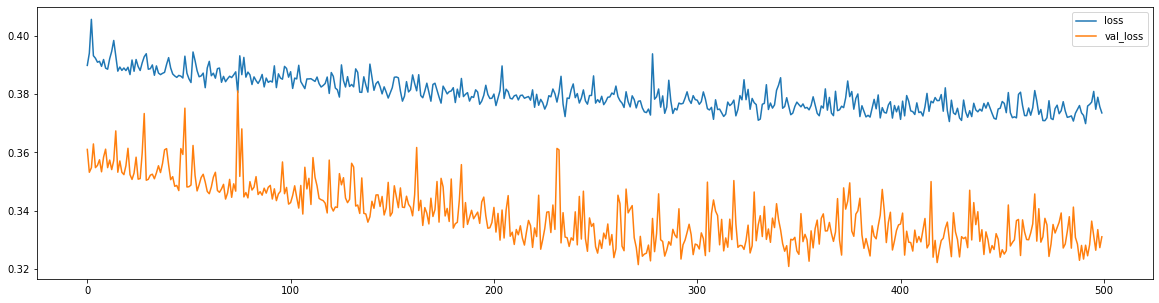

In [186]:
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [187]:
def get_answer(pred):
    return np.where(pred>0.5, 1, 0).squeeze()

pred_train = model.predict(processed_X)
answer_train = get_answer(pred_train)

In [188]:
def compare_test(answer, y):
    compare = (answer==y)
    print(compare.value_counts()[True] / len(compare))
compare_test(answer_train,train_Y)

0.8406285072951739


In [189]:
tdf = preprocessing_df(test_df)
tdf['Fare'] = scaler.transform(tdf['Fare'].to_numpy().reshape(-1,1))
tdf

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,3,1,1,-0.490783,1,1,0
1,3,0,1,-0.507479,1,2,1
2,2,1,2,-0.453367,1,1,0
3,3,1,1,-0.474005,1,2,0
4,3,0,1,-0.401017,1,2,1
...,...,...,...,...,...,...,...
413,3,1,1,-0.486337,1,2,0
414,1,0,1,1.544246,1,0,0
415,3,1,1,-0.502445,1,2,0
416,3,1,1,-0.486337,1,2,0


In [190]:
test_pred = model.predict(tdf)
answer_test = get_answer(test_pred)

In [191]:
submission_df['Survived'] = answer_test

In [192]:
submission_df.to_csv('submission.csv', index=False)

In [193]:
!kaggle competitions submit -c titanic -f submission.csv -m "test 4"

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 21.6kB/s]
100%|##########| 3.18k/3.18k [00:03<00:00, 1.06kB/s]
